#### Import packages

In [ ]:
# conda create -n insb python=3.7 anaconda
# conda activate insb
# pip install tensorflow
# pip install keras
# pip install opencv-python

# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# pip install np_utils and then restart your terminal if you get error
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

#### Setup training directory 

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Dataset directory
dataset_path = os.path.join(ROOT_DIR, "dataset/NumtaDB")

In [3]:
os.listdir(dataset_path)

['y_train.npy', 'y_val.npy', 'x_val.npy', 'x_train.npy']

In [4]:
# Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

#### Helper functions

In [5]:
def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. 
            It will plot the image and its true label. If the image is plotted after prediction 
            phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. 
            It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
#         img_sq=np.squeeze(img,axis=2)
#         plt.imshow(img_sq,cmap='gray')
        plt.imshow(img)
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            if y is not None:
                plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()


#### Load training data

In [6]:
x_train = np.load("{}/x_train.npy".format(dataset_path))
y_train = np.load("{}/y_train.npy".format(dataset_path))

x_val = np.load("{}/x_val.npy".format(dataset_path))
y_val = np.load("{}/y_val.npy".format(dataset_path))

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(57636, 96, 96, 3) (57636, 10) (14409, 96, 96, 3) (14409, 10)


#### Train, Validation and Test set

Usually, the trainining set is split up into `train` and `validation` set. The model is trained using the train set and the performance is evaluated using the validation set. If the performance is not satisfactory the model is tinkered to get a better performance on the validation data. In this way the model actually overfits on the validation set. To get an estimate of its performance on unseen data we use the `test` data. In theory, test data should not be used to modify model parameters.

In [7]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

57636 train samples
14409 validation samples


In [8]:
x_train_rs = []

for i in x_train:
    i =cv2.resize(i,(28, 28),interpolation=cv2.INTER_AREA)
    x_train_rs.append(i)
    
x_train_rs = np.array(x_train_rs)
x_train_rs.shape

(57636, 28, 28, 3)

In [9]:
x_val_rs = []

for i in x_val:
    i =cv2.resize(i,(28, 28),interpolation=cv2.INTER_AREA)
    x_val_rs.append(i)
    
x_val_rs = np.array(x_val_rs)
x_val_rs.shape

(14409, 28, 28, 3)

#### Our final training and validation set

In [10]:
print(x_train_rs.shape, y_train.shape, x_val_rs.shape, y_val.shape)

(57636, 28, 28, 3) (57636, 10) (14409, 28, 28, 3) (14409, 10)


#### Let's see a sample

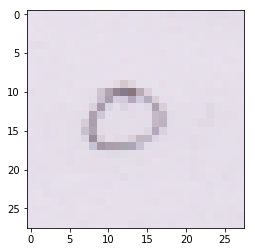

In [11]:
img = x_train_rs[5]
plt.imshow(img)

#### What could these be?

In [12]:
print(img.shape)
print(img)

(28, 28, 3)
[[[230 225 236]
  [231 224 236]
  [229 223 235]
  ...
  [227 220 232]
  [228 221 233]
  [228 222 234]]

 [[231 225 235]
  [231 225 236]
  [230 224 235]
  ...
  [228 222 233]
  [228 221 232]
  [227 221 232]]

 [[232 226 237]
  [231 224 236]
  [231 224 237]
  ...
  [229 222 234]
  [227 222 234]
  [228 221 234]]

 ...

 [[229 223 235]
  [230 223 235]
  [228 223 234]
  ...
  [229 223 234]
  [229 222 234]
  [228 223 233]]

 [[230 223 235]
  [230 224 235]
  [230 223 236]
  ...
  [229 223 234]
  [229 222 233]
  [225 220 232]]

 [[230 224 236]
  [230 224 236]
  [230 223 235]
  ...
  [228 223 234]
  [228 222 233]
  [228 222 234]]]


#### And this? :/ 

In [13]:
print(y_train[0])
print("What is this vector? I thought we were mapping digit images to numbers...")

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
What is this vector? I thought we were mapping digit images to numbers...


In [14]:
img_rs = img / 255
print(img_rs.shape)
print(img_rs)

(28, 28, 3)
[[[0.90196078 0.88235294 0.9254902 ]
  [0.90588235 0.87843137 0.9254902 ]
  [0.89803922 0.8745098  0.92156863]
  ...
  [0.89019608 0.8627451  0.90980392]
  [0.89411765 0.86666667 0.91372549]
  [0.89411765 0.87058824 0.91764706]]

 [[0.90588235 0.88235294 0.92156863]
  [0.90588235 0.88235294 0.9254902 ]
  [0.90196078 0.87843137 0.92156863]
  ...
  [0.89411765 0.87058824 0.91372549]
  [0.89411765 0.86666667 0.90980392]
  [0.89019608 0.86666667 0.90980392]]

 [[0.90980392 0.88627451 0.92941176]
  [0.90588235 0.87843137 0.9254902 ]
  [0.90588235 0.87843137 0.92941176]
  ...
  [0.89803922 0.87058824 0.91764706]
  [0.89019608 0.87058824 0.91764706]
  [0.89411765 0.86666667 0.91764706]]

 ...

 [[0.89803922 0.8745098  0.92156863]
  [0.90196078 0.8745098  0.92156863]
  [0.89411765 0.8745098  0.91764706]
  ...
  [0.89803922 0.8745098  0.91764706]
  [0.89803922 0.87058824 0.91764706]
  [0.89411765 0.8745098  0.91372549]]

 [[0.90196078 0.8745098  0.92156863]
  [0.90196078 0.87843137 

#### See some samples

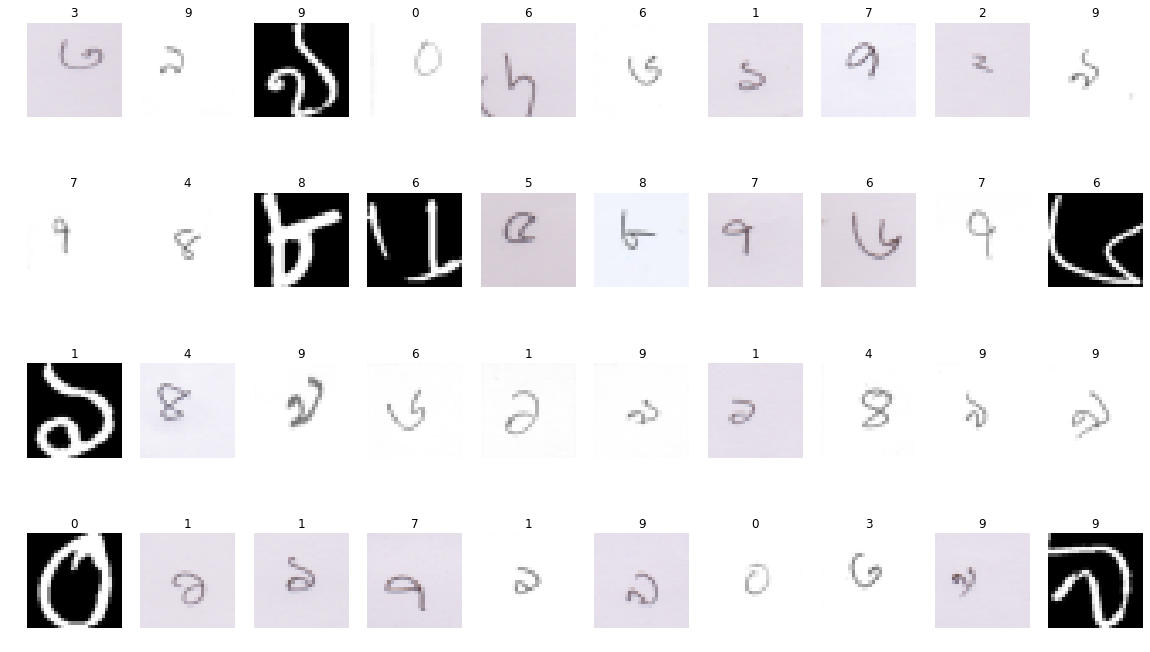

In [15]:
imshow_group(x_train_rs[-40:], y_train[-40:]) 

#### Some samples from validation set

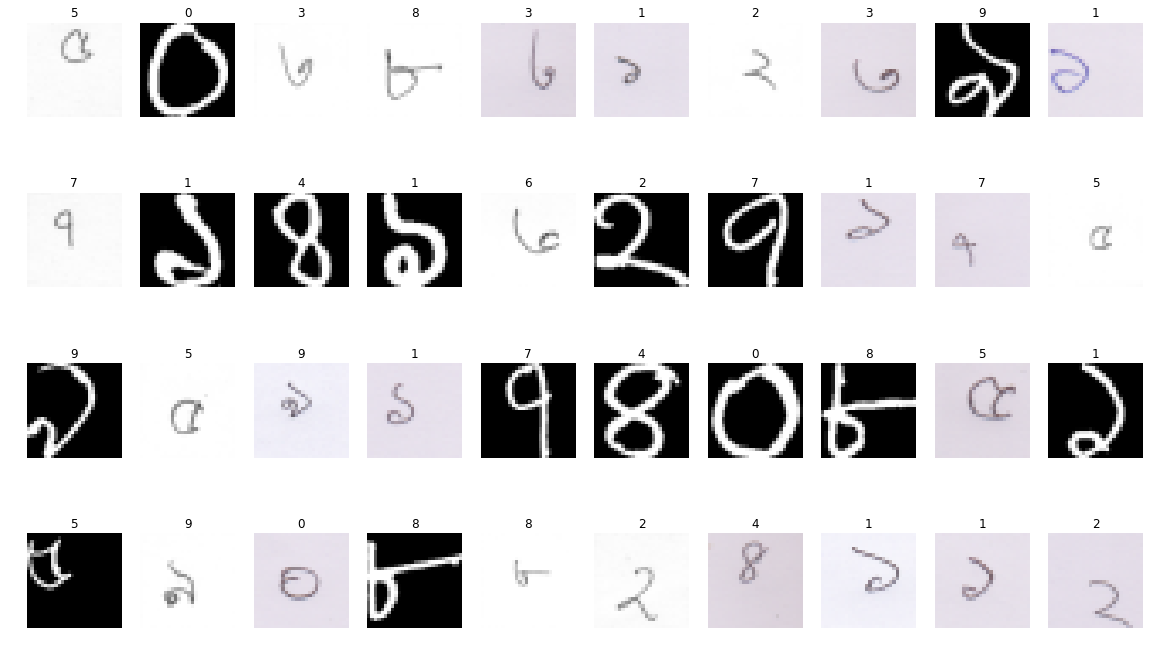

In [16]:
imshow_group(x_val_rs[-40:], y_val[-40:]) 

# Model Architecture

Now we shall get familiar with some basic layers which crusial in building a Convolutional Neural Network.

## Dense layer

Below we see a regular neural network with an input layer, a hidden dense layer and an output layer. The input layer is our data and the output layer is our target. Notice that each neuron of the hidden layer is connected with every neuron of the incoming layer. Such a layer is called a `Dense` layer. 

## Convolutional layer

An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input.

## Convolution Operation

Let's consider a convolutional layer with 2 filters. All the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows. The input volume is of size 5x5x3. In the CONV layer we have two filters of size 3×3, and they are applied with a stride of 2.  Moreover, notice that a padding of 1 pixel is applied to the input volume, making the outer border of the input volume zero. The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias.

## ReLU

The rectified linear layer induces a nonlinearity in the values of the incoming layer. The function of ReLU can be summarized mathematically as $f(x) = max(x, 0)$ i.e. it only passes the values $x$ which are greater than zero.


## Maxpooling layer

The max pooling layer downsamples the input. This reduces computational cost due the reduction in dimension and provides translational invariance to the internal representation. 

## Softmax layer

The softmax function squashes the outputs of each unit to be between 0 and 1 such that the total sum of the outputs is equal to 1. The output of the softmax function is equivalent to a categorical probability distribution, it tells you the probability that any of the classes are true.

* https://github.com/Kulbear/deep-learning-nano-foundation/wiki/ReLU-and-Softmax-Activation-Functions

The filter weights are updated to minimize a defined `loss function`. The updates are done using a form of `gradient descent` and the gradients are calculated using `backpropagation` algorithm. These concepts are not covered in this notebook

## Building a Convolutional Neural Network

We shall build a small model based on the classic [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) architecture. We shall use only three convolutional layers. Each convolution layer has rectified linear unit (ReLU) activation which is followed by a max pooling layer. The convolution layers are followed by two dense layers. 

In [17]:
x_train_rs = x_train_rs.astype('float32')
x_val_rs = x_val_rs.astype('float32')
x_train_rs /= 255
x_val_rs /= 255

print('x_train shape:', x_train_rs.shape)
print(x_train_rs.shape[0], 'train samples')
print(x_val_rs.shape[0], 'test samples')

x_train shape: (57636, 28, 28, 3)
57636 train samples
14409 test samples


In [27]:
def lenet():
    input_layer=Input(shape=(RESIZE_DIM,RESIZE_DIM,3))
    
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    #new
    #x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    #x=Conv2D(filters=128,kernel_size=(3,3),padding='same', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    #x=Conv2D(filters=256,kernel_size=(3,3),padding='same', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    #x=Conv2D(filters=128,kernel_size=(3,3),padding='valid', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Flatten()(x)
    
    x=Dense(units=64)(x)
    x=Dense(units=10)(x) 
    
    output_layer=Activation('softmax')(x)
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model

model=lenet()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 8)         608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 32)          0         
__________

In [28]:
path_model='my_first_awesome_model.h5' # save model at this location after each epoch

In [29]:
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one

model=None
model=lenet() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate

# fit the model
h=model.fit(x=x_train_rs,     
            y=y_train, 
            batch_size=64, 
            epochs=50, 
            verbose=1, 
            validation_data=(x_val_rs,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )


Train on 57636 samples, validate on 14409 samples
Epoch 1/50
57636/57636 [==============================] - 21s 360us/step - loss: 1.3613 - acc: 0.5340 - val_loss: 0.7273 - val_acc: 0.7804
Epoch 2/50
57636/57636 [==============================] - 20s 351us/step - loss: 0.5889 - acc: 0.8198 - val_loss: 0.4882 - val_acc: 0.8555
Epoch 3/50
57636/57636 [==============================] - 20s 353us/step - loss: 0.4379 - acc: 0.8666 - val_loss: 0.4079 - val_acc: 0.8804
Epoch 4/50
57636/57636 [==============================] - 21s 359us/step - loss: 0.3749 - acc: 0.8841 - val_loss: 0.3599 - val_acc: 0.8953
Epoch 5/50
57636/57636 [==============================] - 23s 394us/step - loss: 0.3353 - acc: 0.8965 - val_loss: 0.3396 - val_acc: 0.9026
Epoch 6/50
57636/57636 [==============================] - 20s 346us/step - loss: 0.3119 - acc: 0.9035 - val_loss: 0.3542 - val_acc: 0.8917
Epoch 7/50
20608/57636 [=========>....................] - ETA: 12s - loss: 0.2849 - acc: 0.9097

KeyboardInterrupt: 

In [ ]:
def lenet_modified():
    input_layer=Input(shape=(RESIZE_DIM,RESIZE_DIM,3))
    
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    # stack more convolutional layers
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=128,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=256,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=128,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Flatten()(x)
    
    x=Dense(units=64)(x)
    x=Dense(units=10)(x) 
    
    output_layer=Activation('softmax')(x)
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model

model=lenet_modified()
model.summary()

to be continued....